# Classification. Linear models and KNN

In [214]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [215]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [216]:
from sklearn.exceptions import NotFittedError

In [217]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_values = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-(X @ weights.T)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        sum_l = 0
        for i in range(x.shape[0]):
            item =  np.log(1 + np.exp(-weights[1:] @ x[i] * y[i]))
            sum_l += item
        return sum_l / x.shape[0] + weights.T @ weights / (2 * self.C)
        
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            self.loss_values.append(self.get_loss(X, self.weights_, y))
            grad_sum = 0
            for i in range(y.shape[0]):
                item = y[i] * X_ext[i, :] * (1 - 1 / (1 + np.exp(-X_ext[i, :] @ self.weights_ * y[i])))
                grad_sum += item
            delta = -grad_sum / X_ext.shape[0] + self.weights_/self.C
            self.weights_ -= self.eta * delta
            wt = self.weights_ + self.eta * delta
            if np.linalg.norm((self.weights_ - wt)) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        #return [1 if p > 0.5 else 0 for p in self.predict_proba(X)]
        if hasattr(self, 'weights_'):
            cl = self.predict_proba(X)
            return np.where(cl < 0.5, -1, 1)
        else:
            raise NotFittedError('is not fitted yet')

In [218]:
from sklearn import datasets
from sklearn import metrics

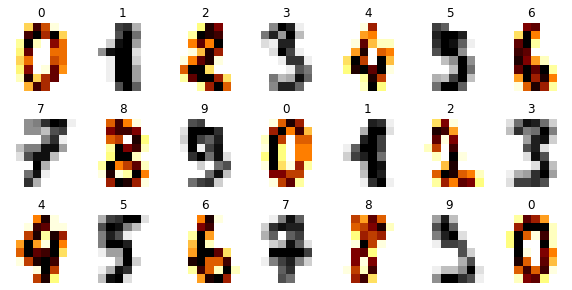

In [219]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [220]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [221]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [222]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [223]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [224]:
lr_clf.fit(X_train, y_train)

In [225]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [226]:
model = CustomLogisticRegression()

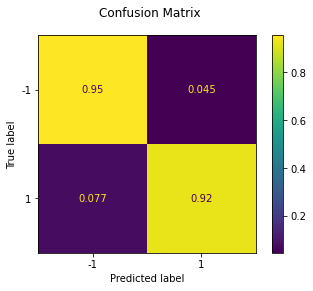

In [227]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [228]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [229]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

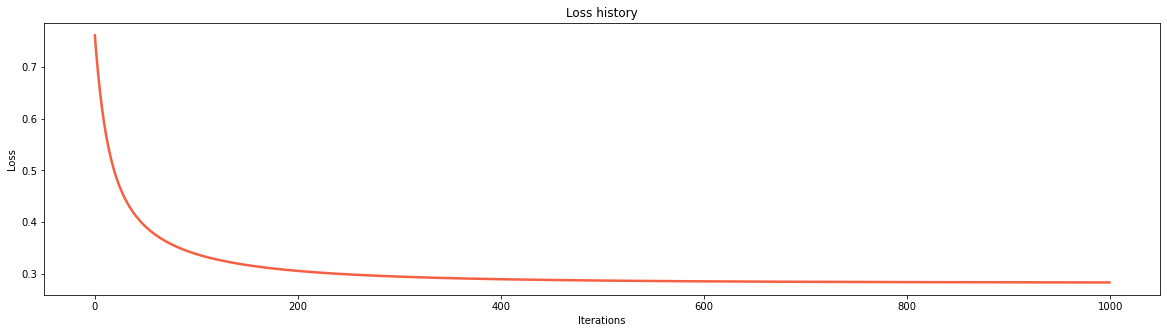

In [230]:
## your code

plt.figure(figsize=(20, 5))
sns.lineplot(x=np.arange(len(model.loss_values)), y=model.loss_values, color='#f56042', linewidth=2.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss history');

> *As number of an iteration increases, loss value decreases.*

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [231]:
## your code

etas = []
eta = [0.0001, 0.001, 0.01, 0.05]
for et in eta:
    model = CustomLogisticRegression(eta=et)
    model.fit(X_train, y_train)
    etas.append(model.loss_values)

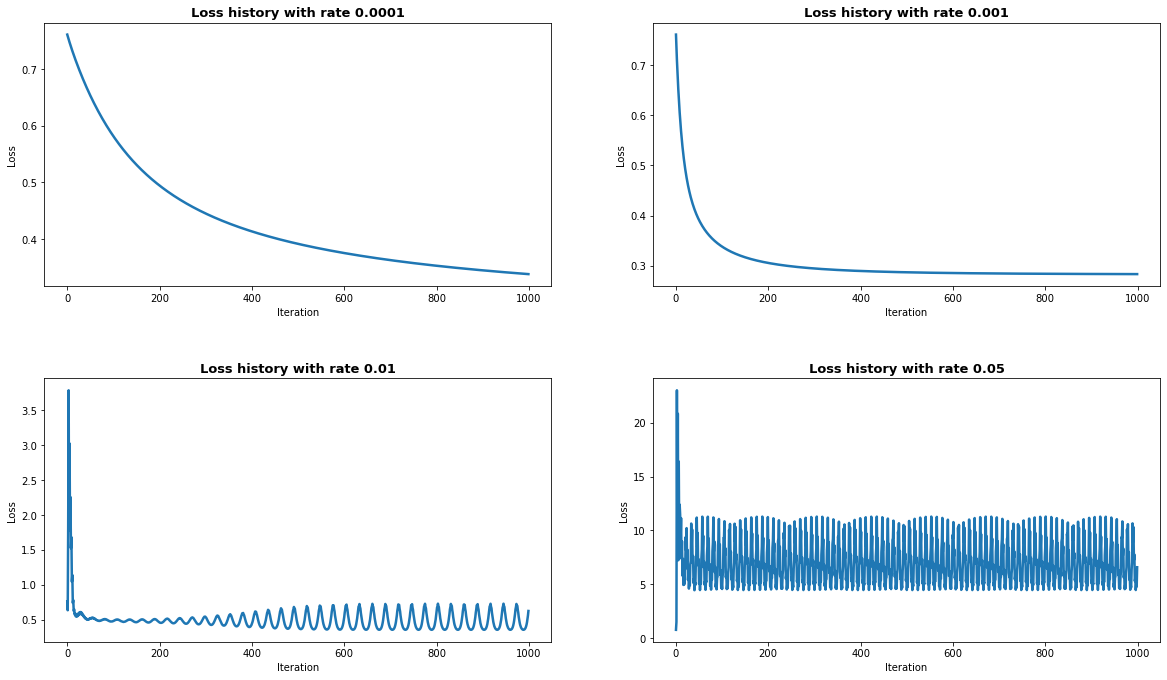

In [232]:
plt.figure(figsize=(20, 20))

for i in np.arange(len(etas)):    
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(bottom=0.45, hspace=0.35)
    sns.lineplot(x = np.arange(len(etas[i])), y=etas[i], linewidth=2.5)
    plt.title(f'Loss history with rate {eta[i]}', fontsize=13, weight='bold')
    plt.xlabel('Iteration') 
    plt.ylabel('Loss')

plt.show()

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [233]:
## your code
train_acc, test_acc = [], []
c_values = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5]
for value in c_values:
    model = CustomLogisticRegression(C = value)
    model.fit(X_train, y_train)
    #train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    #print(train_acc, test_acc)
    train_acc.append(metrics.accuracy_score(y_train, model.predict(X_train)))
    test_acc.append(metrics.accuracy_score(y_test, model.predict(X_test)))
   

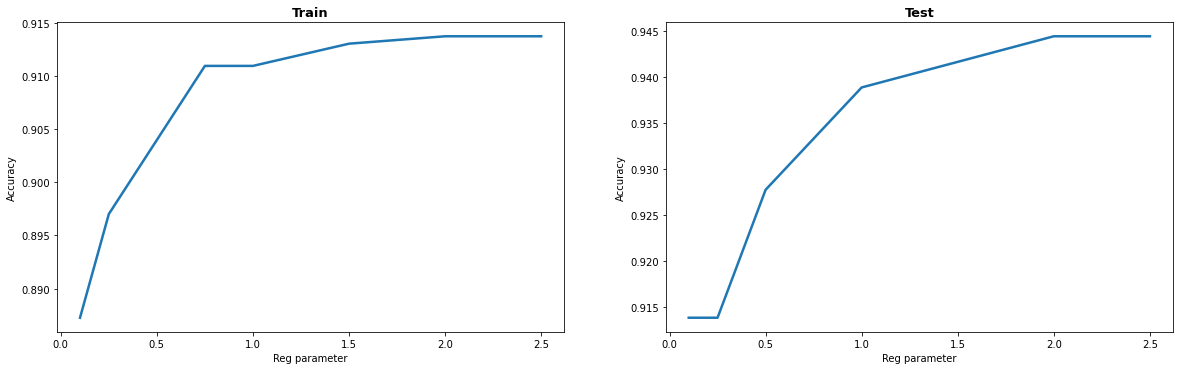

In [234]:
plt.figure(figsize=(20, 10))
  
plt.subplot(1, 2, 1)
plt.subplots_adjust(bottom=0.45, hspace=0.35)
sns.lineplot(x = c_values, y = train_acc, linewidth=2.5)
plt.title(f'Train', fontsize=13, weight='bold')
plt.xlabel('Reg parameter') 
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.subplots_adjust(bottom=0.45, hspace=0.35)
sns.lineplot(x = c_values, y = test_acc, linewidth=2.5)
plt.title(f'Test', fontsize=13, weight='bold')
plt.xlabel('Reg parameter') 
plt.ylabel('Accuracy')

plt.show()

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

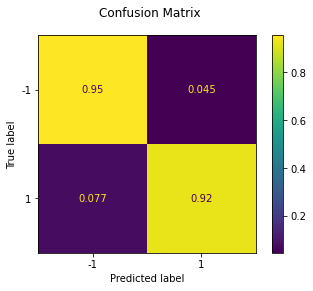

0.9109255393180237 0.9388888888888889


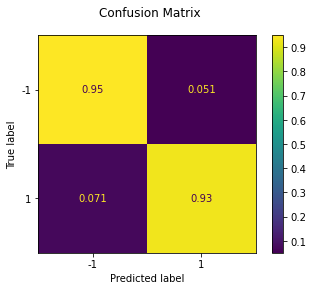

0.9116214335421016 0.9388888888888889


Text(0, 0.5, 'Loss')

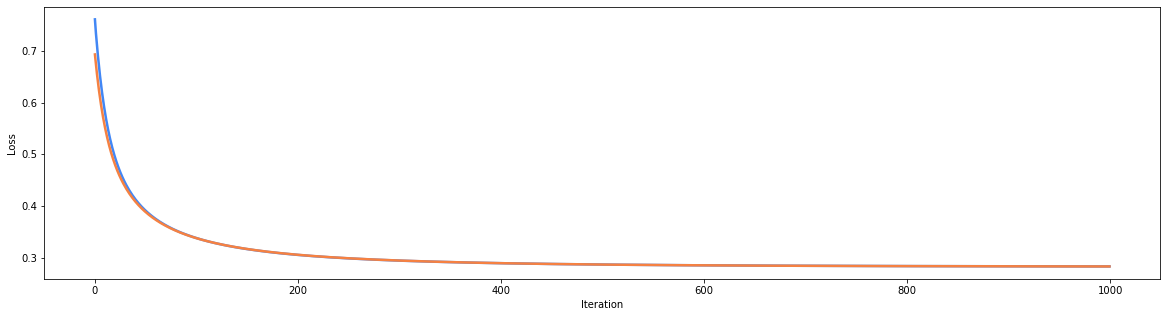

In [235]:
## your code

model_random = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model_random, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

model_zero = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model_zero, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

plt.figure(figsize=(20, 5))
plt.plot(model_random.loss_values, label='Training', color='#4287f5', linewidth=2.5)
plt.plot(model_zero.loss_values, label='Training', color='#f58142', linewidth=2.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [236]:
from sklearn.metrics.pairwise import pairwise_distances
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return pairwise_distances(X, Y)
        
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        class_weights = []
        for el in self.classes_:
            class_weights.append(np.sum(weights[y==el]))
        return class_weights
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
                
            # <your code>

            
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        self.probabilities_all.append(np.amax(self.predict_proba(X), axis=1))
        return np.argmax(self.predict_proba(X), axis=1)

In [237]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [238]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [239]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

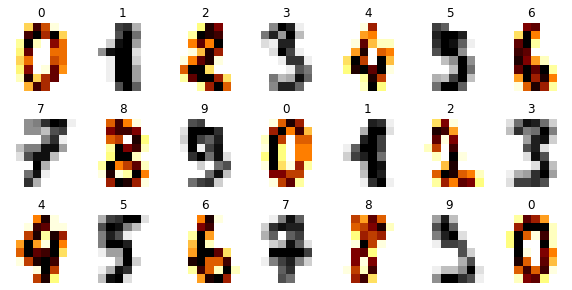

In [240]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [241]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [245]:
PATH = "./data/"

In [246]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'), dtype={'Age': np.float64}).set_index('PassengerId')
data.columns = [column.lower() for column in data.columns]

In [247]:
data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [248]:
## your code


In [249]:
print (data[['sex', 'survived']].groupby(['sex'], as_index=False).count())

      sex  survived
0  female     43886
1    male     56114


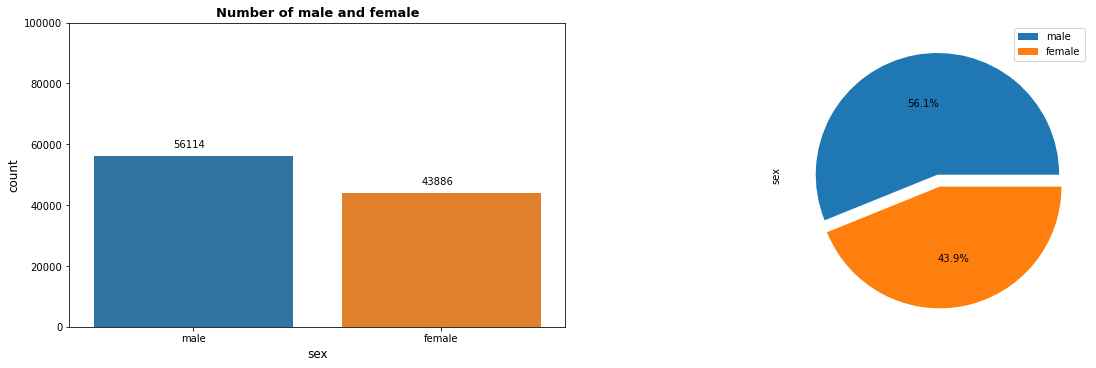

In [250]:
plt.figure(figsize=(20, 13))

plt.subplot(1, 2, 1)
plt.subplots_adjust(top=0.45, wspace=0.25) 
ax1 = sns.countplot(x='sex', data=data)
for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() + 0.32, p.get_height() + 3000))
plt.title('Number of male and female', fontsize=13, weight='bold')
plt.xlabel('sex', fontsize= 12)
plt.ylabel('count', fontsize= 12)
plt.ylim(0, 100000)

plt.subplot(1, 2, 2)
plt.subplots_adjust(top=0.45, wspace=0.25) 
data['sex'].value_counts().plot.pie(explode=[0,0.1], labels = ['',''], autopct='%1.1f%%')
plt.legend(labels=['male', 'female'])

plt.show()

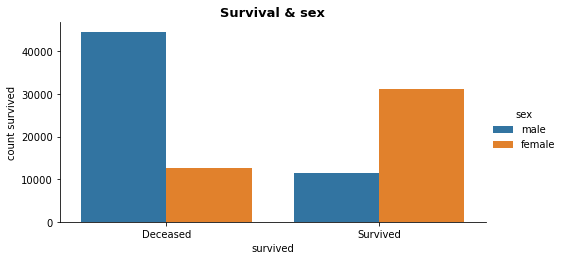

In [251]:
# Survival & sex
ax2 = sns.catplot(x='survived', data=data, kind='count', hue='sex',  aspect=2, height=3.5)
plt.title('Survival & sex', fontsize=13, weight='bold')
plt.ylabel('count survived')
plt.xticks([0,1], ['Deceased', 'Survived'])

plt.show()

      sex  survived
0  female  0.711525
1    male  0.205795


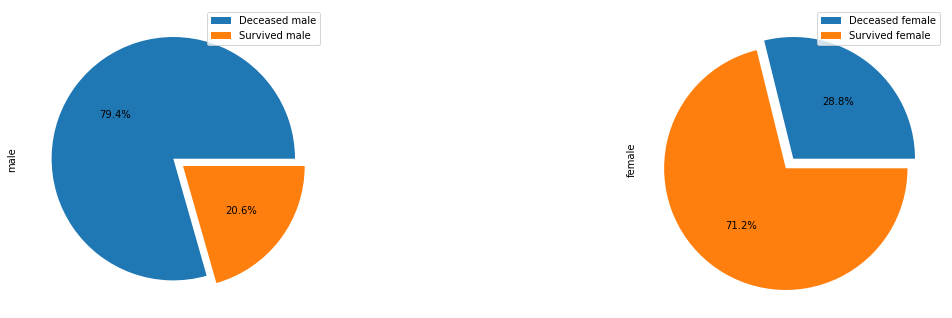

In [252]:
# Since the number of men and women is different, the absolute values do not reflect reality. 
# For a more detailed study, consider the relative indicators.

print(data[['sex', 'survived']].groupby(['sex'], as_index = False).mean())

cte = data.groupby('survived')['sex'].value_counts().unstack()

plt.figure(figsize=(20, 13))

plt.subplot(1, 2, 1)
plt.subplots_adjust(top=0.45, wspace=0.25) 
cte['male'].plot.pie(explode=[0,0.1], labels = ['',''], autopct='%1.1f%%')
plt.legend(labels=['Deceased male', 'Survived male'])

plt.subplot(1, 2, 2)
plt.subplots_adjust(top=0.45, wspace=0.25) 
cte['female'].plot.pie(explode=[0,0.1], labels = ['',''], autopct='%1.1f%%')
plt.legend(labels=['Deceased female', 'Survived female'])

plt.show()

< your thoughts >
> Yes, there is a relationship between gender and survival. We see that the probability of survival in women is higher and is approximately 70%, among men only 20% survived. I think this is due to the fact that they put women and children in the boats first of all.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

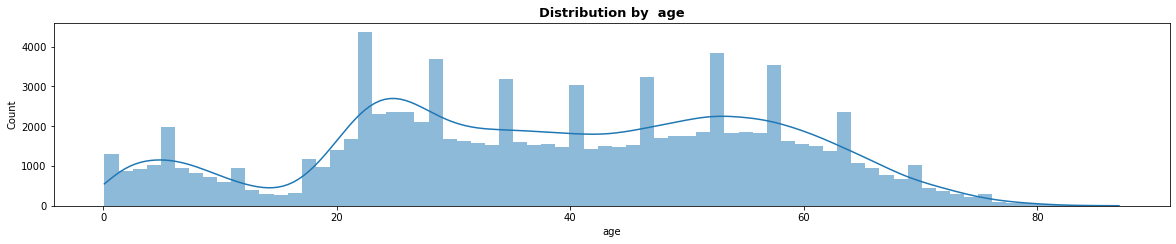

In [253]:
## your code

features_num = ['age']

plt.figure(figsize=(20, 13))

for i, col in enumerate(features_num):    
    plt.subplot(2, 1, i + 1)
    plt.subplots_adjust(bottom=0.45, hspace=0.20) 
    plt.title('Distribution by  ' + col, fontsize=13, weight='bold')
    sns.histplot(data.loc[:,col], kde=True, linewidth=0, palette='Set3', alpha=0.5)

plt.show()

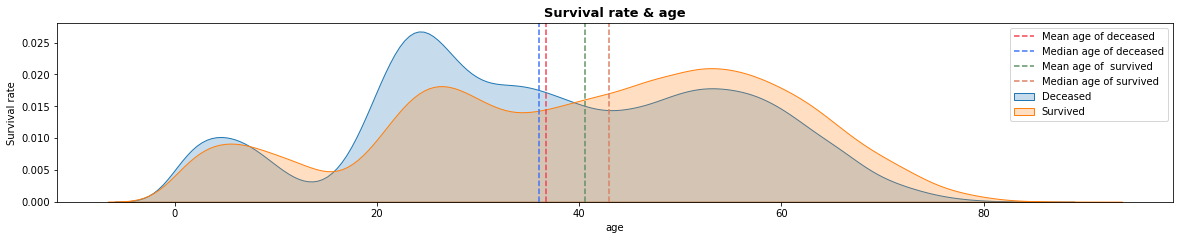

In [254]:
plt.figure(figsize=(20, 13))

for i, col in enumerate(features_num):    
    plt.subplot(2, 1, i + 1)
    plt.subplots_adjust(bottom=0.45, hspace=0.25)
    sns.kdeplot(data.loc[(data['survived'] == 0), col], label = 'Deceased', shade = True)
    sns.kdeplot(data.loc[(data['survived'] == 1), col], label = 'Survived', shade = True)
    plt.ylabel('Survival rate')
    plt.title('Survival rate & ' + col, fontsize=13, weight='bold')
    
plt.axvline(x=data[data['survived'] == 0]['age'].mean(),linestyle = '--', color = '#f54254', label = 'Mean age of deceased')
plt.axvline(x=data[data['survived'] == 0]['age'].median(),linestyle = '--', color = '#4275f5', label = 'Median age of deceased')
plt.axvline(x=data[data['survived'] == 1]['age'].mean(),linestyle = '--', color = '#619166', label = 'Mean age of  survived')
plt.axvline(x=data[data['survived'] == 1]['age'].median(),linestyle = '--', color = '#db8265', label = 'Median age of survived')
plt.legend()
plt.show()

In [255]:
res_all = np.array([['All passengers', round(data['age'].mean(),1), round(data['age'].median(),3)], 
                       ['Survived', round(data[data['survived'] == 1]['age'].mean(),1), round(data[data['survived'] == 1]['age'].median(),3)],
                    ['Deceased', round(data[data['survived'] == 0]['age'].mean(),1), round(data[data['survived'] == 0]['age'].median(),3)]])
res_finish = pd.DataFrame(res_all,columns = ['model','Mean', 'Median'])
res_finish

,model,Mean,Median
0,All passengers,38.4,39.0
1,Survived,40.6,43.0
2,Deceased,36.7,36.0


< your thoughts >
> The average and median age of all passengers are close and are 39 years. At the same time, the distribution of survivors and deceased differs. There are more young people among the dead, and older people among the survivors. It can be explained by the affluence of passengers and, accordingly, class of tickets purchased.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

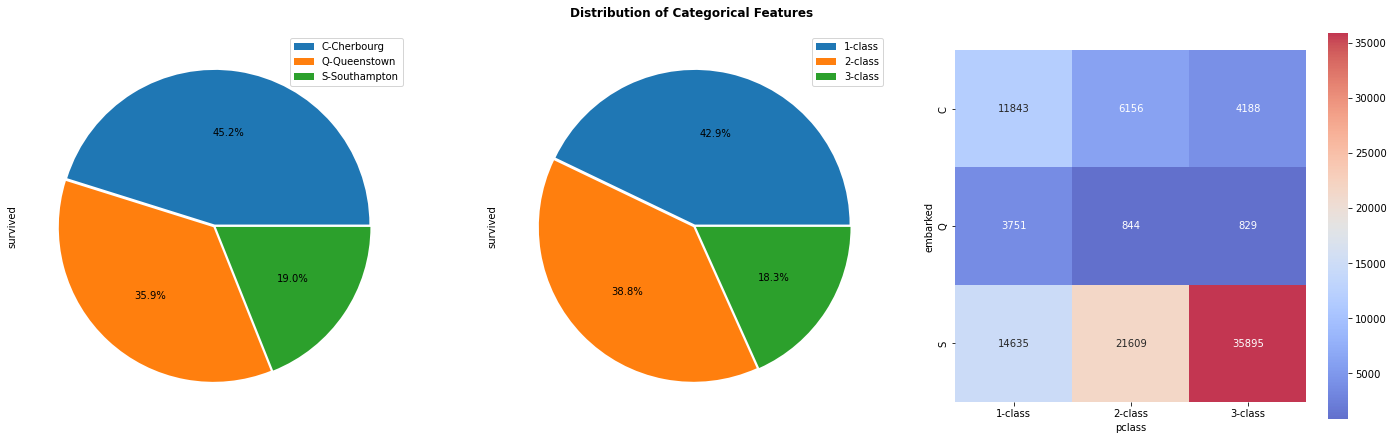

In [256]:
## your code

embarked_data = data.pivot_table(values=['survived'], index='embarked')
pclass_data = data.pivot_table(values=['survived'], index='pclass')
embarked_pcl= data.groupby('embarked')['pclass'].value_counts().reset_index(name='number')
comb_data = pd.pivot(embarked_pcl, index='embarked', columns='pclass', values='number') \
    .reset_index() \
    .rename(columns={1:'1-class', 2:'2-class', 3:'3-class'})

plt.figure(figsize=(20, 6))
plt.suptitle('Distribution of Categorical Features', fontsize = 12, fontweight = 'bold')
plt.subplot(1, 3, 1)
embarked_data['survived'].plot.pie(explode=[0.01,0.01,0.01], labels = ['','',''], autopct='%1.1f%%')
plt.legend(labels=['C-Cherbourg', 'Q-Queenstown', 'S-Southampton'])

plt.subplot(1, 3, 2)
pclass_data['survived'].plot.pie(explode=[0.01,0.01,0.01], labels = ['','',''], autopct='%1.1f%%')
plt.legend(labels=['1-class', '2-class', '3-class'])

plt.subplot(1, 3, 3)
sns.heatmap(comb_data[['1-class', '2-class', '3-class']], 
    annot=True, fmt='d', 
    xticklabels='auto', 
    yticklabels=comb_data['embarked'], 
    alpha=0.8, 
    cmap= 'coolwarm',
    square=True)
plt.ylabel('embarked')
plt.tight_layout()

< your thoughts >
> Exploring distribution of fare values based on where the passenger embarked from, the class of ticket. Most of the passengers were traveling 3rd class and many third class passengers died. It can be explained by the fact that richer people, as well as women and children, were saved first of all. Most of the men were in the 3rd class. Most 3rd class passengers landed in Southampton, so there were more deaths from the above port.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [257]:
## your code

data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,100000.0,NaN,NaN,NaN,0.42774,0.494753,0.0,0.0,0.0,1.0,1.0
pclass,100000.0,NaN,NaN,NaN,2.10691,0.837727,1.0,1.0,2.0,3.0,3.0
name,100000,92144,"Johnson, John",31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,100000,2,male,56114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,96708.0,NaN,NaN,NaN,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0
sibsp,100000.0,NaN,NaN,NaN,0.39769,0.862566,0.0,0.0,0.0,1.0,8.0
parch,100000.0,NaN,NaN,NaN,0.45456,0.950076,0.0,0.0,0.0,1.0,9.0
ticket,95377,75331,A/5,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,99866.0,NaN,NaN,NaN,43.92933,69.58882,0.68,10.04,24.46,33.5,744.66
cabin,32134,26992,C19828,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
# null values
null_values = data.isnull().sum()/len(data)*100
null_values

survived     0.000
pclass       0.000
name         0.000
sex          0.000
age          3.292
sibsp        0.000
parch        0.000
ticket       4.623
fare         0.134
cabin       67.866
embarked     0.250
dtype: float64

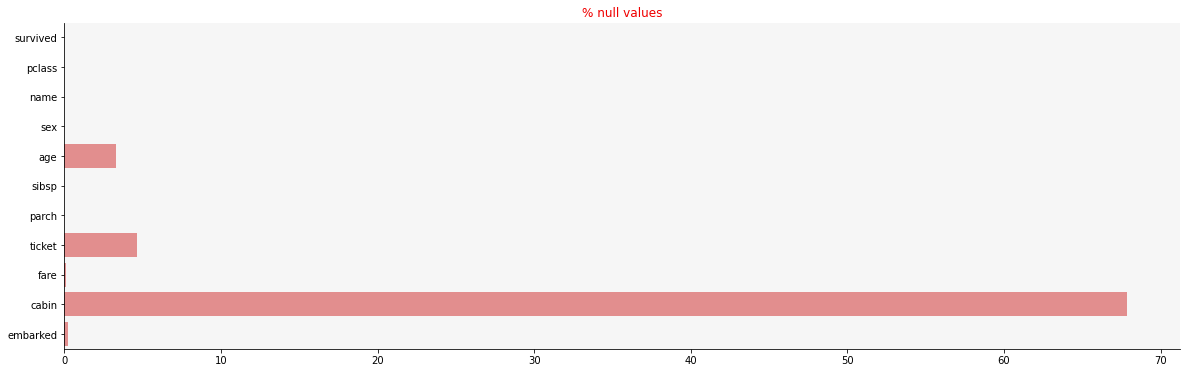

In [259]:
plt.figure(figsize=(20, 6))

sns.barplot(x = null_values.values, y = list(null_values.index),   color = '#F08080')
plt.title('% null values', color = '#F00000')

ax = plt.gca()
ax.set_facecolor('#f6f6f6')
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

In [260]:
# We will check %unique values in column
feature_cols = data.drop(['survived'], axis=1).columns

# Getting all the data that are not of "object" type.
num_cols = data[feature_cols].select_dtypes(include=['int64','float64']).columns
cat_cols = data[feature_cols].select_dtypes(exclude=['int64','float64']).columns

for col in cat_cols:
    print(f"{col} : {round(data[col].nunique()/len(data)*100, 3)}")

name : 92.144
sex : 0.002
ticket : 75.331
cabin : 26.992
embarked : 0.003


> - Almost 70% of the data is missing in the feature cabine. Let's fill in the missing data with the value "None", and in the rest, for example, highlight the initial letters.
> - 'Name' and 'Ticket' columns have more than 92% & 75% unique values respectively. They don't give any information to the model just as is. Let's delete its. 
> - Numerical features of age and fare can be filled either with the average (median) value, also depending on another feature, or these lines can be deleted, since their number is very small.
> - A categorical feature embarked can be filled in with the most frequent value or completely deleted, since their number is too small.
>
> Any filling in of missing values will result in data misrepresentation. Therefore, if there are many missing values, then experiments should be carried out with filling in the missing data or deleting them, and then with training the model and checking on the validation set.

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [261]:
## your code

def missing_data(data):

    # Fill 'age' and 'fare' value with their mean value
    for col in ['age', 'fare']:
        data[col] = data[col].fillna(round(data[col].mean(), 0))

    # Fill 'embarked' and 'ticket' values with their mode value
    for col in ['embarked', 'ticket']:
        data[col] = data[col].fillna(data[col].mode()[0])

    # Fill it with 'None' if the value is not present
    data['cabin'] = data['cabin'].fillna('None')
    data['cabintype'] = data['cabin'].str[0]
    data.drop(['cabin'], axis = 1, inplace = True)

    # Drop %unique values in column
    data.drop(['name', 'ticket'], axis = 1, inplace = True)

    return data


def feature_eng(data):
    
    data['family'] = data['sibsp'] + data['parch'] + 1
    data.drop(['sibsp', 'parch'], axis=1, inplace=True)

    #data = data.join(pd.get_dummies(data[['sex', 'embarked']], drop_first=True))
    data['sex'] = data['sex'].map({'male': 1,'female': 0})
    data['embarked'] = data['embarked'].map({'S': 1,'Q': 0, 'C': 0})
    
    data.drop(['cabintype'], axis=1, inplace=True)

    return data

def standSc(x_value):
    
    # Standardization
    sc = StandardScaler()
    x_value = sc.fit_transform(x_value)
    
    return x_value

In [262]:
df_fill = data.copy()
df_fill = missing_data(df_fill)
df_fill_en = feature_eng(df_fill)

df_fill_en.head()

,survived,pclass,sex,age,fare,embarked,family
PassengerId,,,,,,,
0,1,1,1,38.00,27.14,1,3
1,0,3,1,38.00,13.35,1,1
2,0,3,1,0.33,71.29,1,4
3,0,3,1,19.00,13.04,1,1
4,1,3,1,25.00,7.76,1,1


In [263]:
X_train, X_val, y_train, y_val = train_test_split(df_fill_en.drop(['survived'],axis=1), 
                                                    data['survived'], test_size=0.10, 
                                                    random_state=101)

In [264]:
logmodel = LogisticRegression(max_iter=1000, random_state = 42, tol=0.0001)
scores = cross_validate(logmodel, X_train, y_train, scoring='accuracy', cv=5)
print(scores['test_score'])

[0.76355556 0.76394444 0.7645     0.76683333 0.76238889]


In [265]:
knnmodel = KNeighborsClassifier(n_neighbors = 3) 
scores = cross_validate(knnmodel, X_train, y_train, scoring='accuracy', cv=5)
print(scores['test_score'])

[0.70838889 0.70761111 0.70933333 0.71355556 0.70416667]


>  I'll used cross-validation and calculated accuracy, as we can see Logistical Regression performs better than KNN (accuracy for KNN ranges between 0.70-0.71 while accuracy for Logistical regression about 0.76).

In [266]:
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_val)

round(accuracy_score(predictions, y_val), 3)

0.765

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [267]:
## your code

param = {
    'penalty' : ['l1','l2','elasticnet'],
    'C': [0.0001,0.001,0.01,0.1],
    'tol' : [0.00001],
    'random_state': [42],
    'max_iter': [5000,15000, 30000]
}

lr = LogisticRegression()
gr = GridSearchCV(lr, param, refit=True, scoring = 'accuracy', cv=5)
best_model = gr.fit(X_train, y_train)
print(best_model.best_params_)


{'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'tol': 1e-05}


In [268]:
predictions = best_model.predict(X_val)

round(accuracy_score(predictions, y_val), 3)

0.765

> For hyperparameter tuning, I tried sklearn's GridSearchCV but that didn't improve the results either. I use logistic regression as the final model.

In [269]:

test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'), dtype={'Age': np.float64})
test.columns = [column.lower() for column in test.columns]
test.columns

Index(['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

<AxesSubplot:>

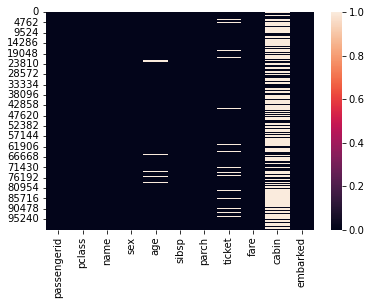

In [270]:
sns.heatmap(test.isnull())

In [271]:
df_test = test.copy()
df_test = missing_data(df_test)
df_test_en = feature_eng(df_test)
df_test_val = df_test_en.copy()
df_test_val.drop(['passengerid'], axis = 1, inplace = True)
df_test_val.head()

,pclass,sex,age,fare,embarked,family
0,3,1,19.0,63.01,1,1
1,3,0,53.0,5.81,1,1
2,1,0,19.0,38.91,0,1
3,2,1,25.0,12.93,1,1
4,1,0,17.0,26.89,0,3


In [272]:
logmodel.fit(X_train, y_train)
test_prediction = logmodel.predict(df_test_val)
test_prediction = [ 1 if y>=0.5 else 0 for y in test_prediction]
test_prediction

[0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


In [273]:
df_result = pd.DataFrame({'PassengerId': df_test_en['passengerid']})
df_result['Survived'] = logmodel.predict(df_test_val)
df_result

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [274]:
df_result.to_csv('part3_submit.csv' , index=False)

![image](https://user-images.githubusercontent.com/60570588/161915922-8b02d797-8881-4306-beaf-93c33b506849.png)